Adrian Gruszczynski / Yann Salimi

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
%matplotlib inline

# Random probability distribution X with support {-50,50}

In [4]:
class XNormDiscrete:

    def __init__(self, mu, sigma, size):
        self.mu = mu
        self.sigma = sigma
        self.size = size

    def random(self):
        x = np.random.normal(self.mu, self.sigma, self.size)
        x = self.minmax_scale(x, -51, 50)
        return x

    def minmax_scale(self, a, x, y):
        min, max = np.max(a), np.min(a)
        range = max - min
        a = (a - min) / range
        return a * (y - x) + x

# Hill Climbing implementation

In [42]:
class HillClimbing:

    def __init__(self, x, epsilon):
        self.x = x
        self.epsilon = epsilon
        self.n = len(x)
        self.hx_max = 0
        self.hvarx_max = 0
        self.lambda_ = .01

    def get_hx_max(self):
        pu = np.ones(self.n) * 1 / self.n
        self.hx_max = ss.entropy(pu, base=2)
        print('Maximal entropy for given X: ', self.hx_max)

    def get_hvarx_max(self):
        vx = np.var(self.x)
        var_max = vx + self.epsilon * vx  # opt for epsilon % better variance
        self.get_hx_max()
        self.hvarx_max = self.hx_max + (self.lambda_ * var_max)
        print('Opt for entropy + variance: ', self.hvarx_max)

    def normalize(self, px):
        return px / np.sum(px)

    def climb_entropy(self):
        best_hx = 0
        px = ss.norm.pdf(self.x, 1, .2)
        print('Initial entropy', ss.entropy(px, base=2))
        self.plothist(self.x, 'Initial X')
        self.get_hx_max()
        px = self.normalize(px)
        while best_hx < self.hx_max - self.epsilon:
            rn = np.random.lognormal(size=self.n)
            rn = rn / np.sum(rn)
            px += rn
            hx = ss.entropy(px, base=2)
            if hx > best_hx:
                best_hx = hx
            else:
                px -= rn
        px = self.normalize(px)
        x = np.random.choice(self.x, size=self.n, p=px)
        self.plothist(x, 'H(X) maximized')
        return best_hx

    def climb_entropy_variance(self):
        best_hvarx = 0
        px = ss.norm.pdf(self.x, 1, .2)
        print('Initial variance', np.var(self.x))
        print('Initial entropy', ss.entropy(px, base=2))
        self.plothist(self.x, 'Initial X')
        px = self.normalize(px)
        self.get_hvarx_max()
        while best_hvarx < self.hvarx_max:
            rn = np.random.lognormal(size=self.n)
            rn = rn / np.sum(rn)
            px += rn
            hx = ss.entropy(px, base=2)
            x = np.random.choice(self.x, size=self.n, p=self.normalize(px))
            vx = np.var(x)
            hvarx = hx + (self.lambda_ * vx)
            if hvarx > best_hvarx:
                best_hvarx = hvarx
            else:
                px -= rn
        self.plothist(x, 'Maximized H(X) + .01 * V(X)')
        print('Achieved variance: ', vx)
        return best_hvarx

    def kl_div_pq(self, mu, sigma):
        z = np.random.normal(loc=mu, scale=sigma, size=self.n)
        pz = ss.norm.pdf(z, loc=mu, scale=sigma)
        pz = self.normalize(pz)
        return np.sum(ss.entropy(self.x, pz, base=2))

    def kl_div_qp(self, mu, sigma):
        z = np.random.normal(loc=mu, scale=sigma, size=self.n)
        pz = ss.norm.pdf(z, loc=mu, scale=sigma)
        pz = self.normalize(pz)
        return np.sum(ss.entropy(pz, self.x, base=2))

    def climb_kl_div(self, iter_n):
        kl_div, best_kl_div = 0, 100
        while best_kl_div > self.epsilon:
            mu = np.random.uniform(-.1, .1)
            sigma = np.random.uniform(0, .1)
            if iter_n == 'pq':
                kl_div = self.kl_div_pq(mu, sigma)
            elif iter_n == 'qp':
                kl_div = self.kl_div_qp(mu, sigma)
            else:
                return
            if kl_div < best_kl_div:
                best_kl_div = kl_div
        self.plotpdf(mu, sigma)
        return best_kl_div
    
    def plothist(self, x, title):
        plt.hist(x, bins=len(x))
        plt.title(title)
        plt.axis([-51, 51, 0, 15])
        plt.show()

    def plotpdf(self, mu, sigma):
        z = np.random.normal(loc=mu, scale=sigma, size=self.n)
        z.sort()
        y = np.random.choice(z, size=self.n, p=self.x)
        y.sort()
        fit_z = ss.norm.pdf(z, np.mean(z), np.std(z))
        fit_z = self.normalize(fit_z)
        fit_y = ss.norm.pdf(y, np.mean(y), np.std(y))
        fit_y = self.normalize(fit_y)
        plt.plot(z, fit_z, '-o')
        plt.plot(y, fit_y, '-o')
        plt.show()

# Maximize the entropy $H(X)$

Draw 400 random samples from normal distribution with $\mu = 1$ and $\sigma = .2$

Aim for maximal entropy $H(X) = H$(uniform distribution)

Initial entropy 2.8808416495525826


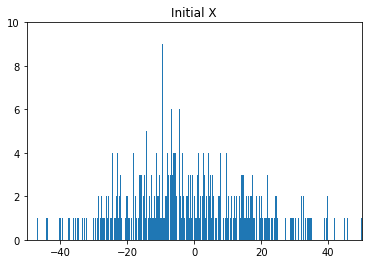

Maximal entropy for given X:  8.643856189774725


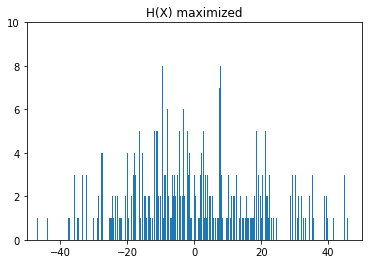

Achieved entropy 8.643806580861233


In [19]:
_x = XNormDiscrete(1, .2, 400).random()
_hx_max = HillClimbing(_x, 0.00005).climb_entropy()
print('Achieved entropy', _hx_max)

# Maximize $H(X) + \lambda * \mathbb{V}(X)$

Draw 400 random samples from normal distribution with  $\mu=1$  and  $\sigma=.2$

Aim for maximal entropy $H(X) = H$(uniform distribution) and 20% better $\lambda * \mathbb{V}(X)$

Initial variance 361.9755249032042
Initial entropy 2.8808416495525826


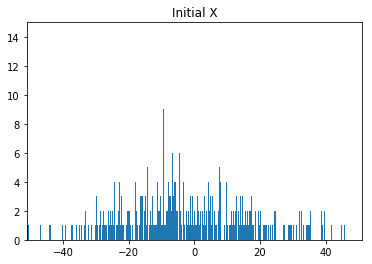

Maximal entropy for given X:  8.643856189774725
Opt for entropy + variance:  12.987562488613175


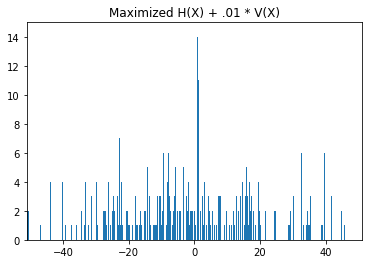

Achieved variance:  449.58276331538343
Achieved entropy + variance:  13.0201593379701


In [43]:
_hvarx_max = HillClimbing(_x, .2).climb_entropy_variance()
print('Achieved entropy + variance: ', _hvarx_max)

# Minimize $\mathbb{KL}(P(Y)||Q(Z))$

Opt for $\mathbb{KL}(P(Y)||Q(Z)) \leq 0.77$

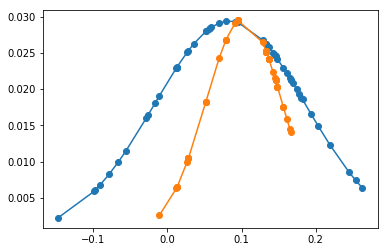

Minimized D_KL(P(Y), Q(Z)) 0.7636239579511297


In [38]:
_y = np.array(pd.read_csv('Y.txt', header=None)).reshape(50, )
_kl_min = HillClimbing(_y, .77).climb_kl_div('pq')
print('Minimized D_KL(P(Y), Q(Z))', _kl_min)

Opt for $\mathbb{KL}(P(Z)||Q(Y)) \leq 2.76$

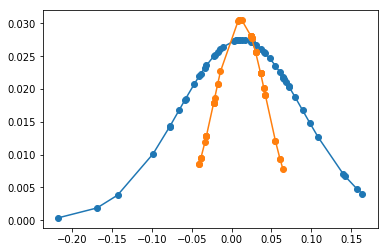

Minimized D_KL(Q(Y), P(Z)) 2.7567036766022692


In [40]:
_kl_min = HillClimbing(_y, 2.78).climb_kl_div('qp')
print('Minimized D_KL(Q(Y), P(Z))', _kl_min)

Both $Z's$ are different, because the Kullback-Leibler divergence is not symmetrical.

Thus changing the mean to minimize $\mathbb{KL}(P(Y)||Q(Z))$ results in a different $Z$ then the other way around.